In [22]:
from ultralytics import YOLO
import numpy as np
import cv2
from PIL import Image
import torch
import os
import json

## To `submition.json`

In [30]:
def predict_and_save_json(model, img_dir, output_file):
    data = []

    # Пройдем по всем изображениям в папке
    for img_file in os.listdir(img_dir):
        if img_file.endswith(".jpg") or img_file.endswith(".png"):
            img_path = os.path.join(img_dir, img_file)

            # Сделаем предсказание с помощью YOLO
            results = model(img_path)
            
            # Получаем информацию о классах, координатах и вероятностях
            names = results[0].names  # Имена классов
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(np.int32)  # Координаты bbox в формате (xmin, ymin, xmax, ymax)
            scores = results[0].boxes.conf.cpu().numpy()  # Вероятности
            classes = results[0].boxes.cls.cpu().numpy().astype(int)  # Классы объектов

            # Создание структуры для текущего изображения
            img_data = {
                "filename": img_file,
                "objects": []
            }

            # Пройдем по всем предсказаниям и добавим их в JSON-формат
            for score, cls, bbox in zip(scores, classes, boxes):
                img_data["objects"].append({
                    "obj_class": str(cls),  # Класс объекта
                    "x": str(bbox[0]),  # xmin
                    "y": str(bbox[1]),  # ymin
                    "width": str(bbox[2] - bbox[0]),  # width (xmax - xmin)
                    "height": str(bbox[3] - bbox[1])  # height (ymax - ymin)
                })
                
            if not img_data['objects']:
                img_data['objects'].append({})
                

            # Добавляем информацию о текущем изображении в общий список
            data.append(img_data)

    # Сохранение всех данных в JSON файл
    with open(output_file, 'w') as json_file:
        json.dump(data, json_file, indent=4)

**Пример формирования submit.json по папке:**

In [32]:
model = YOLO("runs/detect/train69/weights/best.pt")

images_dir = "test_images"  # Путь к папке с изображениями
output_json_file = "test_submit.json"  # Имя выходного SUBMIT JSON-файла

predict_and_save_json(model, images_dir, output_json_file)


image 1/1 /home/user1/hackaton_hacksai/test_images/2.jpg: 512x640 1 plane, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/user1/hackaton_hacksai/test_images/1.jpg: 512x640 (no detections), 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


## Работа с фото

In [17]:
def plot_bboxes(results):
    img = results[0].orig_img # original image
    names = results[0].names # class names dict
    scores = results[0].boxes.conf.cpu().numpy() # probabilities
    classes = results[0].boxes.cls.cpu().numpy() # predicted classes
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(np.int32) # bboxes
    for score, cls, bbox in zip(scores, classes, boxes): # loop over all bboxes
        class_label = names[cls] # class name
        label = f"{class_label} : {score:0.2f}" # bbox label
        lbl_margin = 3 #label margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color=(0, 0, 255),
                            thickness=1)
        label_size = cv2.getTextSize(label, # labelsize in pixels 
                                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                                     fontScale=1, thickness=1)
        lbl_w, lbl_h = label_size[0] # label w and h
        lbl_w += 2* lbl_margin # add margins on both sides
        lbl_h += 2*lbl_margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]), # plot label background
                             (bbox[0]+lbl_w, bbox[1]-lbl_h),
                             color=(0, 0, 255), 
                             thickness=-1) # thickness=-1 means filled rectangle
        cv2.putText(img, label, (bbox[0]+ lbl_margin, bbox[1]-lbl_margin), # write label to the image
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.0, color=(255, 255, 255 ),
                    thickness=1)
    return img

In [6]:
model = YOLO("runs/detect/train69/weights/best.pt")
results = model("test_images/2.jpg", save=True)


image 1/1 /home/user1/hackaton_hacksai/test_images/2.jpg: 512x640 1 plane, 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 126.1ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict2


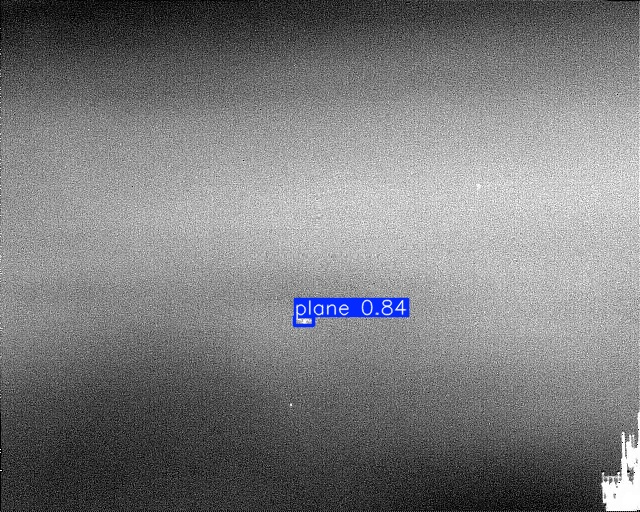

In [12]:
Image.open("runs/detect/predict2/2.jpg")

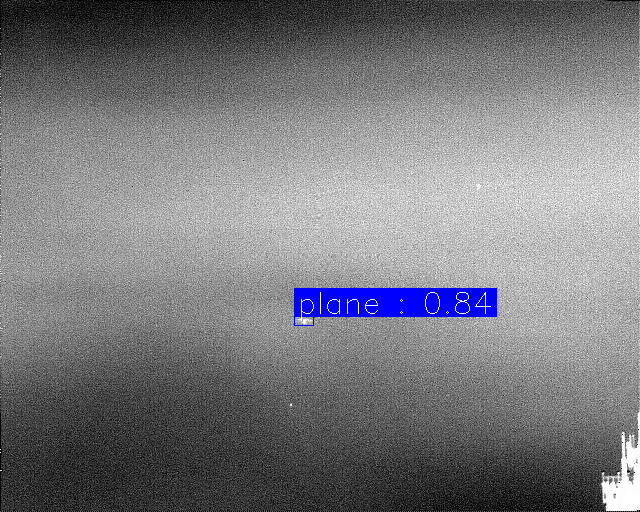

In [20]:
img = plot_bboxes(results)
Image.fromarray(img)

## Работа с видео

In [21]:
results = model.track('test_videos/1.mp4', tracker="custom_tracker.yaml", save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2200) /home/user1/hackaton_hacksai/test_videos/1.mp4: 512x640 1 plane, 9.4ms
video 1/1 (frame 2/2200) /home/user1/hackaton_hacksai/test_videos/1.mp4: 512x640 1 plane, 9.5ms
video 1/1 (frame 3/2200) /home/user1/hackaton_hacksai/test_videos/1.mp4: 512x640 1 plane, 8.7ms
video 1/1 (frame 4/2200) /home/user1/hackaton_hacksai/test_videos/1.mp4: 512x640 1 plane, 10.4ms
video 1/1 (frame 5/2200) /home/user1/hackaton_hacksai/test_videos/1.mp4